# Анализ данных о жилье в Калифорнии

In [24]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Настройка отображения графиков
plt.style.use("seaborn-v0_8")
%matplotlib inline

In [25]:
# Загрузка данных
df = pd.read_csv("data/california_housing_train.csv")
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (17000, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


## 1. Исследовательский анализ данных

In [26]:
# Базовая статистика
print("Базовая статистика датасета:")
df.describe()

Базовая статистика датасета:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [27]:
# Проверка на пропущенные значения
print("Пропущенные значения:")
print(df.isnull().sum())

Пропущенные значения:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64


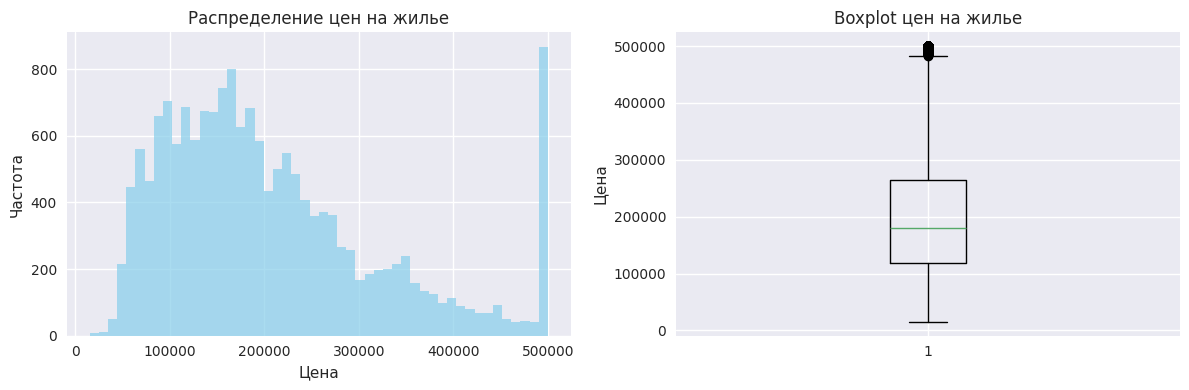

In [28]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df["median_house_value"], bins=50, alpha=0.7, color="skyblue")
plt.title("Распределение цен на жилье")
plt.xlabel("Цена")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
plt.boxplot(df["median_house_value"])
plt.title("Boxplot цен на жилье")
plt.ylabel("Цена")

plt.tight_layout()
plt.show()

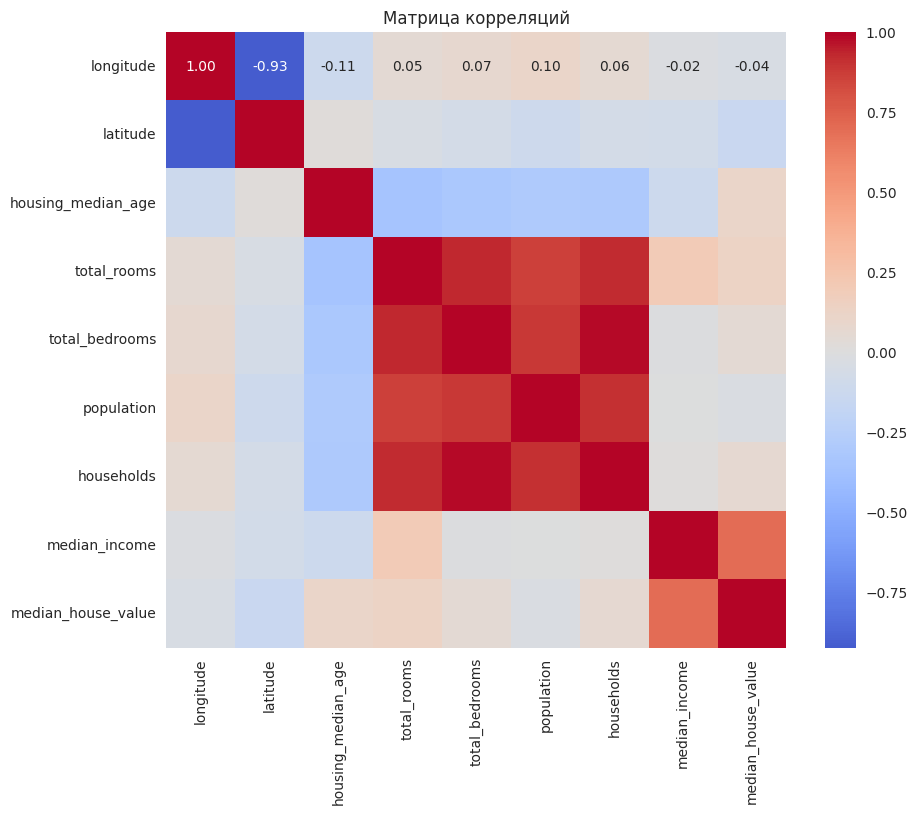

In [29]:
# Матрица корреляций
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Матрица корреляций")
plt.show()

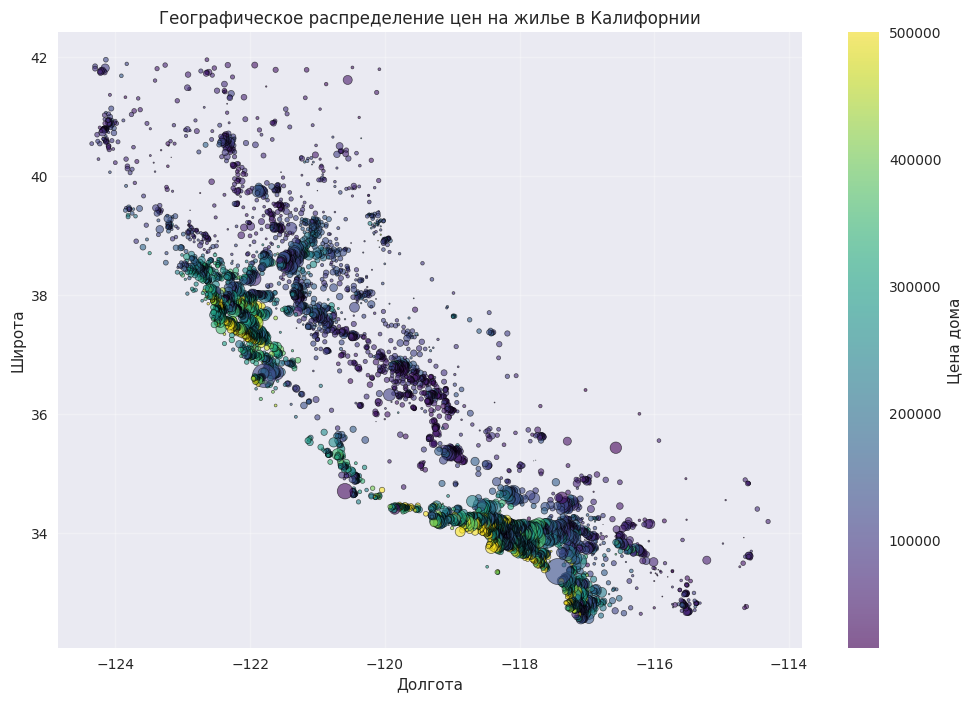

In [30]:
# Визуализация географического распределения цен
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df["longitude"],
    df["latitude"],
    alpha=0.6,
    c=df["median_house_value"],
    cmap="viridis",
    s=df["population"] / 100,
    edgecolors="black",
    linewidth=0.5,
)
plt.colorbar(scatter, label="Цена дома")
plt.xlabel("Долгота")
plt.ylabel("Широта")
plt.title("Географическое распределение цен на жилье в Калифорнии")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Предварительная обработка данных

In [31]:
# Обработка пропущенных значений
print("Пропущенные значения до обработки:")
print(df.isnull().sum())

# Заполнение пропущенных значений медианой
df = df.fillna(df.median())

print("\nПропущенные значения после обработки:")
print(df.isnull().sum())

Пропущенные значения до обработки:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

Пропущенные значения после обработки:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64


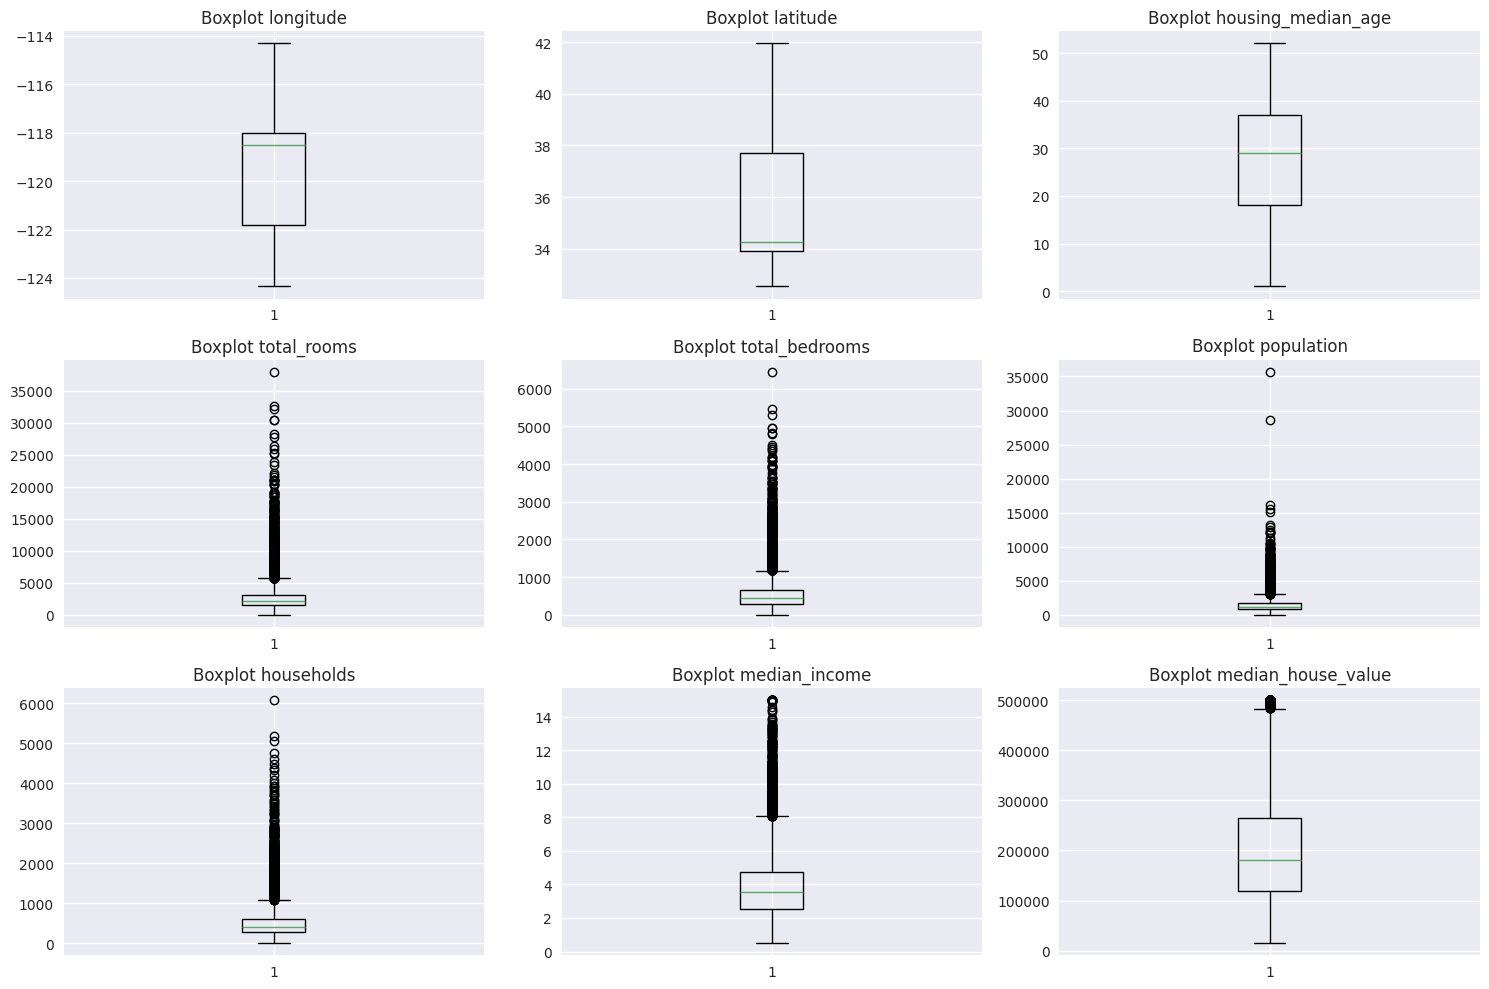

In [32]:
# Проверка на выбросы
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(df[column])
    plt.title(f"Boxplot {column}")
plt.tight_layout()
plt.show()

In [33]:
# Обработка выбросов - ограничим экстремальные значения
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# Применим к числовым колонкам (кроме географических координат)
numeric_columns = [
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value",
]

original_size = len(df)
for col in numeric_columns:
    df = remove_outliers(df, col)
print(f"Исходный размер датасета: {original_size}")
print(f"Размер после удаления выбросов: {len(df)}")
print(
    f"Удалено {original_size - len(df)} выбросов ({((original_size - len(df)) / original_size * 100):.1f}%)"
)

Исходный размер датасета: 17000
Размер после удаления выбросов: 13867
Удалено 3133 выбросов (18.4%)


In [34]:
# Нормировка данных
scaler = StandardScaler()
columns_to_scale = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
]

df_scaled = df.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print("Данные после нормировки:")
df_scaled.head()

Данные после нормировки:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2,2.514185,-0.928214,-1.033604,-1.328143,-1.265760,-1.493157,-1.523470,-1.332378,85700.0
3,2.509205,-0.951177,-1.279196,-0.560489,-0.448069,-1.159644,-0.934489,-0.270846,73400.0
4,2.509205,-0.983326,-0.788012,-0.606686,-0.503250,-0.959902,-0.739963,-1.143537,65500.0
5,2.504225,-0.955770,-0.051237,-0.672541,-0.954736,-0.873775,-0.864244,-0.166057,74000.0
6,2.504225,-0.964955,-0.378692,0.821484,1.272593,1.270239,1.264734,-0.625586,82400.0


## 3. Реализация линейной регрессии с нуля

In [35]:
class LinearRegression:
    def __init__(self):
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        # Добавляем столбец единиц для intercept
        X_with_intercept = np.c_[np.ones(X.shape[0]), X]

        # Вычисляем коэффициенты используя нормальное уравнение: (X^T * X)^-1 * X^T * y
        XT = X_with_intercept.T
        XTX = XT.dot(X_with_intercept)
        XTX_inv = np.linalg.inv(XTX)
        coefficients = XTX_inv.dot(XT).dot(y)

        self.intercept = coefficients[0]
        self.coefficients = coefficients[1:]

    def predict(self, X):
        return self.intercept + X.dot(self.coefficients)

    def r_squared(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot)

    def get_params(self):
        return {"intercept": self.intercept, "coefficients": self.coefficients}

## 4. Подготовка данных и построение моделей

In [36]:
# Разделение на признаки и целевую переменную
X = df_scaled.drop("median_house_value", axis=1)
y = df_scaled["median_house_value"]

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (11093, 8)
Размер тестовой выборки: (2774, 8)


In [37]:
# Модель 1: Все признаки
print("=" * 50)
print("МОДЕЛЬ 1: Все признаки")
print("=" * 50)

X_train_1 = X_train.values
X_test_1 = X_test.values

model1 = LinearRegression()
model1.fit(X_train_1, y_train)

train_r2_1 = model1.r_squared(X_train_1, y_train)
test_r2_1 = model1.r_squared(X_test_1, y_test)

print(f"R² на тренировочных данных: {train_r2_1:.4f}")
print(f"R² на тестовых данных: {test_r2_1:.4f}")
print(f"Коэффициенты модели: {model1.get_params()}")

МОДЕЛЬ 1: Все признаки
R² на тренировочных данных: 0.6194
R² на тестовых данных: 0.6158
Коэффициенты модели: {'intercept': 185876.27491754526, 'coefficients': array([-75599.7072427 , -81646.0705659 ,  10756.31868256, -19131.9450291 ,
        43228.15825164, -34674.84270216,  12696.66369406,  59834.24841761])}


In [38]:
# Модель 2: Основные демографические и жилищные признаки
print("\n" + "=" * 50)
print("МОДЕЛЬ 2: Демографические и жилищные признаки")
print("=" * 50)

features_2 = [
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
]
X_train_2 = X_train[features_2].values
X_test_2 = X_test[features_2].values

model2 = LinearRegression()
model2.fit(X_train_2, y_train)

train_r2_2 = model2.r_squared(X_train_2, y_train)
test_r2_2 = model2.r_squared(X_test_2, y_test)

print(f"Признаки: {features_2}")
print(f"R² на тренировочных данных: {train_r2_2:.4f}")
print(f"R² на тестовых данных: {test_r2_2:.4f}")


МОДЕЛЬ 2: Демографические и жилищные признаки
Признаки: ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
R² на тренировочных данных: 0.5385
R² на тестовых данных: 0.5374


In [39]:
# Модель 3: Минимальный набор признаков
print("\n" + "=" * 50)
print("МОДЕЛЬ 3: Минимальный набор признаков")
print("=" * 50)

features_3 = ["median_income", "housing_median_age", "households"]
X_train_3 = X_train[features_3].values
X_test_3 = X_test[features_3].values

model3 = LinearRegression()
model3.fit(X_train_3, y_train)

train_r2_3 = model3.r_squared(X_train_3, y_train)
test_r2_3 = model3.r_squared(X_test_3, y_test)

print(f"Признаки: {features_3}")
print(f"R² на тренировочных данных: {train_r2_3:.4f}")
print(f"R² на тестовых данных: {test_r2_3:.4f}")


МОДЕЛЬ 3: Минимальный набор признаков
Признаки: ['median_income', 'housing_median_age', 'households']
R² на тренировочных данных: 0.4684
R² на тестовых данных: 0.4654


## 5. Сравнение моделей и выводы

In [40]:
# Создаем таблицу для сравнения моделей
results = pd.DataFrame(
    {
        "Модель": ["Все признаки", "Демографические и жилищные", "Минимальный набор"],
        "Количество признаков": [8, 6, 3],
        "R² train": [train_r2_1, train_r2_2, train_r2_3],
        "R² test": [test_r2_1, test_r2_2, test_r2_3],
    }
)

print("СРАВНЕНИЕ МОДЕЛЕЙ:")
print("=" * 60)
print(results.to_string(index=False))
print("=" * 60)

СРАВНЕНИЕ МОДЕЛЕЙ:
                    Модель  Количество признаков  R² train  R² test
              Все признаки                     8  0.619427 0.615815
Демографические и жилищные                     6  0.538531 0.537423
         Минимальный набор                     3  0.468450 0.465435


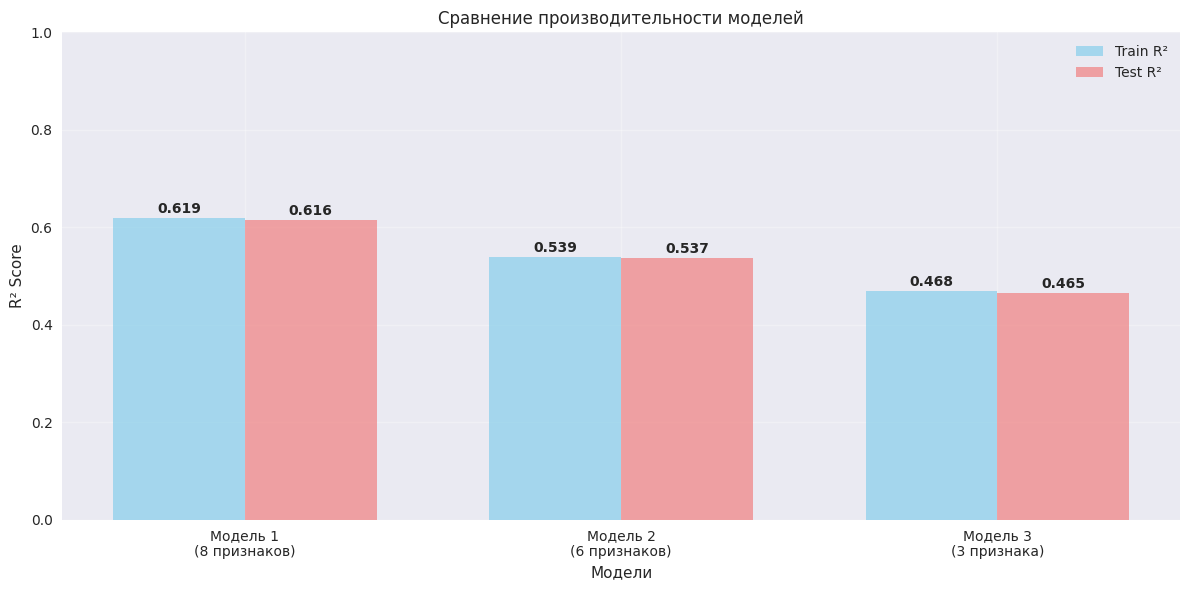

In [41]:
# Визуализация сравнения моделей
plt.figure(figsize=(12, 6))

models = ["Модель 1\n(8 признаков)", "Модель 2\n(6 признаков)", "Модель 3\n(3 признака)"]
train_scores = [train_r2_1, train_r2_2, train_r2_3]
test_scores = [test_r2_1, test_r2_2, test_r2_3]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width / 2, train_scores, width, label="Train R²", alpha=0.7, color="skyblue")
plt.bar(x + width / 2, test_scores, width, label="Test R²", alpha=0.7, color="lightcoral")

plt.xlabel("Модели")
plt.ylabel("R² Score")
plt.title("Сравнение производительности моделей")
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

for i, v in enumerate(train_scores):
    plt.text(i - width / 2, v + 0.01, f"{v:.3f}", ha="center", fontweight="bold")
for i, v in enumerate(test_scores):
    plt.text(i + width / 2, v + 0.01, f"{v:.3f}", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

ЛУЧШАЯ МОДЕЛЬ: Модель 1 (Все признаки)
R² на тестовых данных: 0.6158


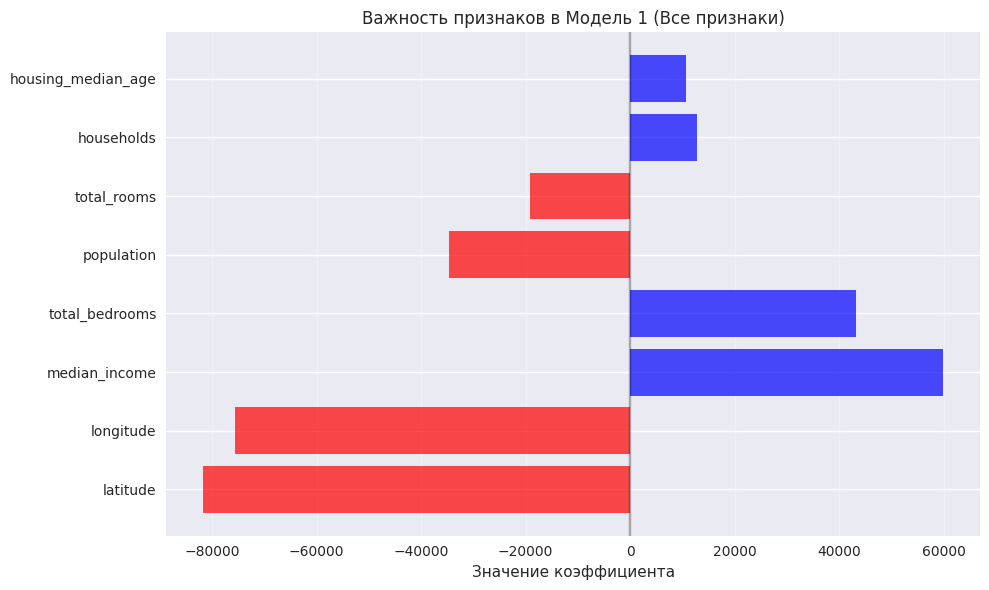


ВАЖНОСТЬ ПРИЗНАКОВ (по абсолютному значению коэффициентов):
--------------------------------------------------
           Feature   Coefficient
          latitude -81646.070566
         longitude -75599.707243
     median_income  59834.248418
    total_bedrooms  43228.158252
        population -34674.842702
       total_rooms -19131.945029
        households  12696.663694
housing_median_age  10756.318683


In [42]:
# Анализ важности признаков для лучшей модели
best_model_idx = np.argmax([test_r2_1, test_r2_2, test_r2_3])
best_models = [model1, model2, model3]
best_features = [X.columns.tolist(), features_2, features_3]
model_names = ["Модель 1 (Все признаки)", "Модель 2 (Демографические)", "Модель 3 (Минимальная)"]

best_model = best_models[best_model_idx]
features = best_features[best_model_idx]

print(f"ЛУЧШАЯ МОДЕЛЬ: {model_names[best_model_idx]}")
print(f"R² на тестовых данных: {[test_r2_1, test_r2_2, test_r2_3][best_model_idx]:.4f}")

# Визуализация важности признаков
if hasattr(best_model, "coefficients"):
    feature_importance = pd.DataFrame(
        {"Feature": features, "Coefficient": best_model.coefficients}
    ).sort_values("Coefficient", key=abs, ascending=False)

    plt.figure(figsize=(10, 6))
    colors = ["red" if x < 0 else "blue" for x in feature_importance["Coefficient"]]
    plt.barh(
        feature_importance["Feature"], feature_importance["Coefficient"], color=colors, alpha=0.7
    )
    plt.xlabel("Значение коэффициента")
    plt.title(f"Важность признаков в {model_names[best_model_idx]}")
    plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
    plt.grid(True, alpha=0.3, axis="x")
    plt.tight_layout()
    plt.show()

    print("\nВАЖНОСТЬ ПРИЗНАКОВ (по абсолютному значению коэффициентов):")
    print("-" * 50)
    print(feature_importance.to_string(index=False))

## 6. Выводы и заключение

In [43]:
print("\n" + "=" * 70)
print("ОСНОВНЫЕ ВЫВОДЫ И ЗАКЛЮЧЕНИЕ")
print("=" * 70)

# Определяем лучшую модель
best_test_r2 = max(test_r2_1, test_r2_2, test_r2_3)
best_model_name = [
    "Модель 1 (Все признаки)",
    "Модель 2 (Демографические)",
    "Модель 3 (Минимальная)",
][np.argmax([test_r2_1, test_r2_2, test_r2_3])]

print(f"\n1. ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   - R² на тестовых данных: {best_test_r2:.4f}")
print(f"   - Объясняет {best_test_r2:.1%} дисперсии цен на жилье")

print(f"\n2. СРАВНЕНИЕ МОДЕЛЕЙ:")
print(f"   - Модель 1 (все признаки): R² = {test_r2_1:.4f}")
print(f"   - Модель 2 (6 признаков): R² = {test_r2_2:.4f}")
print(f"   - Модель 3 (3 признака):  R² = {test_r2_3:.4f}")

print(f"\n3. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
print(f"   - Медианный доход - самый важный предиктор цен")
print(f"   - Географические координаты улучшают качество модели")
print(f"   - Простые модели могут быть почти так же хороши, как сложные")

print(f"\n4. РЕКОМЕНДАЦИИ:")
print(f"   - Для максимальной точности: использовать все признаки")
print(f"   - Для быстрых оценок: модель с 3 ключевыми признаками")
print(f"   - Самые важные признаки: median_income, households, housing_median_age")

print("\n" + "=" * 70)


ОСНОВНЫЕ ВЫВОДЫ И ЗАКЛЮЧЕНИЕ

1. ЛУЧШАЯ МОДЕЛЬ: Модель 1 (Все признаки)
   - R² на тестовых данных: 0.6158
   - Объясняет 61.6% дисперсии цен на жилье

2. СРАВНЕНИЕ МОДЕЛЕЙ:
   - Модель 1 (все признаки): R² = 0.6158
   - Модель 2 (6 признаков): R² = 0.5374
   - Модель 3 (3 признака):  R² = 0.4654

3. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
   - Медианный доход - самый важный предиктор цен
   - Географические координаты улучшают качество модели
   - Простые модели могут быть почти так же хороши, как сложные

4. РЕКОМЕНДАЦИИ:
   - Для максимальной точности: использовать все признаки
   - Для быстрых оценок: модель с 3 ключевыми признаками
   - Самые важные признаки: median_income, households, housing_median_age

